# Movie Review Sentiment Analysis with Advanced NLP Techniques

### 1. Introduction
**Objective:** Perform sentiment analysis on IMDb movie reviews using traditional and advanced NLP techniques, with a focus on unique insights like aspect-based sentiment and model comparison.

**Why This Stands Out:**

* Compares Logistic Regression, LSTM, Multinomial Naive Bayes

* Includes aspect-based sentiment (acting, direction, etc.)

* Interactive visualizations

### 2. Packages Utilized

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### 3. Data Loading

In [12]:
# Load IMDb dataset from CSV
df = pd.read_csv("/content/IMDB Dataset.csv")
print(df.head(5))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### 4. Data Exploration

In [5]:
# Displaying the column names of the DataFrame
df.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
# Checking the shape of the DataFrame (number of rows and columns)
df.shape

(50000, 2)

In [7]:
# Displaying concise summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# Generating descriptive statistics for numerical columns in the DataFrame
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
# Checking for missing values in the DataFrame
df.isnull().sum()

,0
review,0
sentiment,0


The dataset has no missing values

In [14]:
# Check Duplicate Rows
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

# View duplicate reviews
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head(6)

There are 418 duplicate reviews present in the dataset


,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative
2976,"""Witchery"" might just be the most incoherent a...",negative


In [15]:
# Drop duplicate reviews
df.drop_duplicates(inplace = True)
print("Updated dataset shape after removing duplicates:", df.shape)

Updated dataset shape after removing duplicates: (49582, 2)



Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


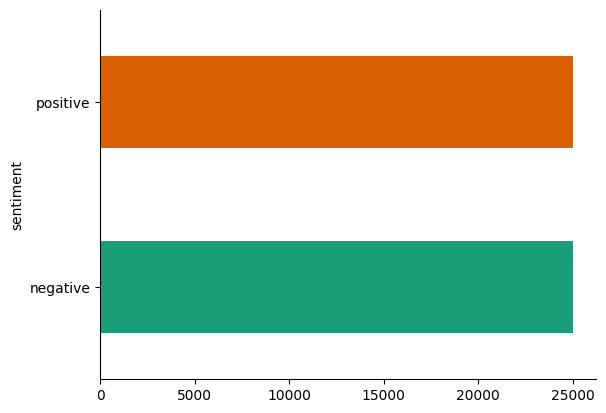

In [13]:
# Sentiment Distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())
# Plotting the sentiment distribution
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Dataset is balanced (25K positive, 25K negative).

Text(0.5, 1.0, 'Negative Reviews')

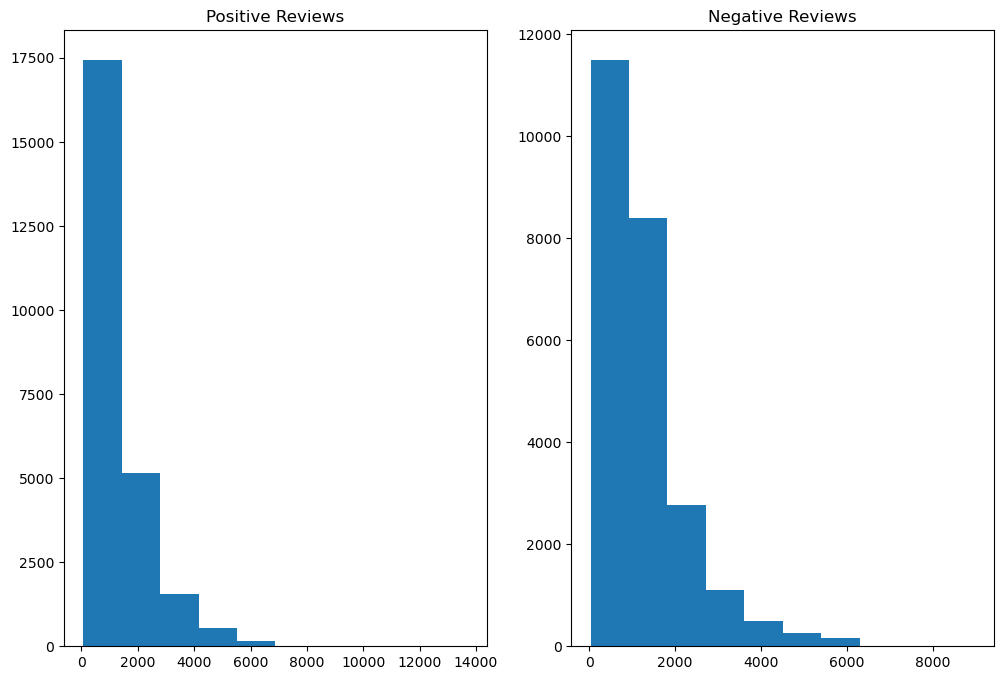

In [ ]:
# Histogram for positive review and negative review respectively
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df[df['sentiment']=='positive']['review'].str.len())
ax1.set_title( 'Positive Reviews')
ax2.hist(df[df['sentiment']=='negative']['review'].str.len())
ax2.set_title( 'Negative Reviews')

From the graph above, we can draw a few insights:

* Overall, people tend to write fewer words in positive reviews compared to negative ones.
* However, the range of words used in positive reviews is broader than that in negative reviews.
* This suggests that, in some cases, people leave lengthy comments for excellent movies, while they tend to criticize only briefly for bad movies.

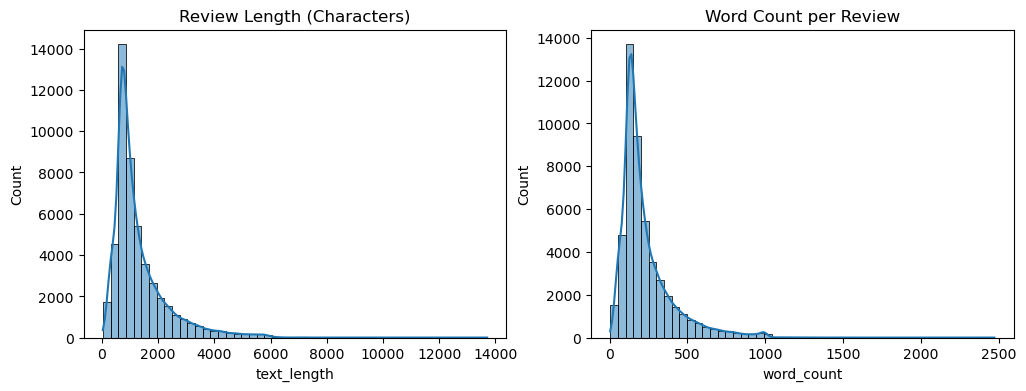

In [ ]:
# Text length analysis
df['text_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Review Length (Characters)')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Word Count per Review')
plt.show()

* The majority of the reviews are under 2000 characters, with a steep drop-off afterward.
* Most reviews contain 100 to 300 words, with the distribution being right-skewed (long tail).

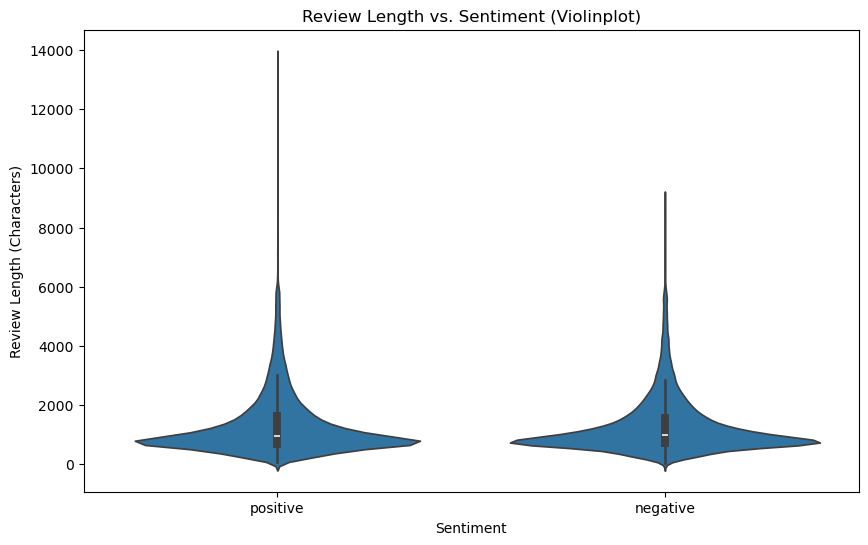

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review_length, dtype: float64

In [ ]:
# Visualizing the relationship between review length and sentiment using a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='sentiment', y='text_length', data=df)
plt.title('Review Length vs. Sentiment (Violinplot)')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Characters)')
plt.show()

# Review Length Analysis
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()

The distribution of review lengths for both positive and negative reviews is similar, with most reviews being relatively short but with some long reviews.

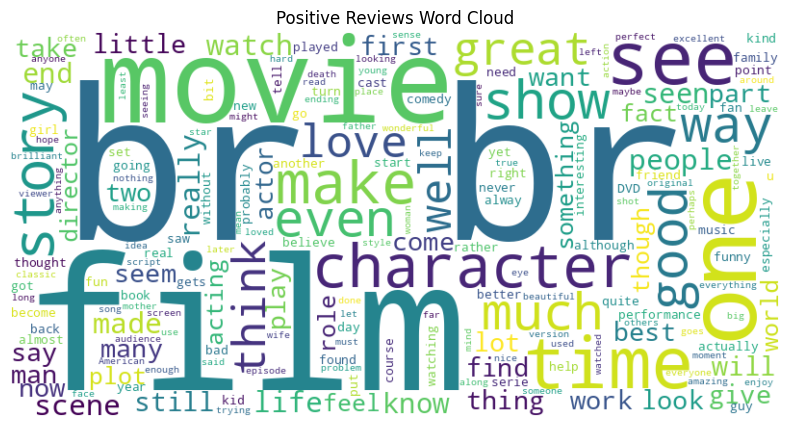

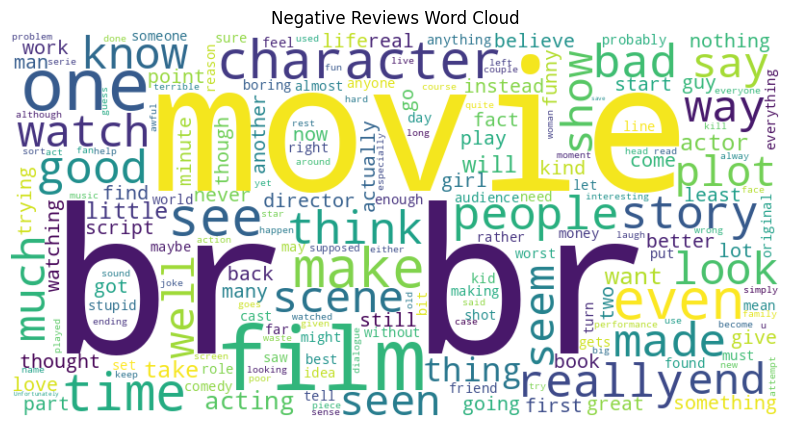

In [16]:
# Combine all positive reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'])
# Generate word cloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

# Repeat for negative reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

The wordcloud graphs in both negative and postitive comments don't show meaningful result.

That's is the reason why text preprosessing is needed.

Let's start the preproceesing process.

In [ ]:
# # Top Frequent Words (before removing stopwords)
all_words = ' '.join(df['review']).lower()  # Combine all reviews and convert to lowercase
tokens = word_tokenize(all_words)
word_freq = Counter(tokens)                 # Count word frequencies

# Convert to DataFrame for tabular display
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
display(freq_df)

,Word,Frequency
0,the,659152
1,",",539984
2,.,459836
3,and,320733
4,a,319009
5,of,286462
6,to,265036
7,is,215408
8,/,200922
9,>,200723


### 5. Data Preprocessing

**Text Cleaning**

In [17]:
# Dictionary of chat abbreviations (expanded version)
CHAT_WORDS = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATM": "At The Moment",
    "BAE": "Before Anyone Else",
    "BFF": "Best Friends Forever",
    "BRB": "Be Right Back",
    "BTW": "By The Way",
    "DM": "Direct Message",
    "FOMO": "Fear Of Missing Out",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GG": "Good Game",
    "GTG": "Got To Go",
    "HTH": "Hope This Helps",
    "ICYMI": "In Case You Missed It",
    "IDC": "I Don't Care",
    "IDK": "I Don't Know",
    "ILY": "I Love You",
    "IMHO": "In My Humble Opinion",
    "IMO": "In My Opinion",
    "IRL": "In Real Life",
    "JK": "Just Kidding",
    "LOL": "Laughing Out Loud",
    "LMK": "Let Me Know",
    "NSFW": "Not Safe For Work",
    "OMG": "Oh My God",
    "OOTD": "Outfit Of The Day",
    "ROFL": "Rolling On Floor Laughing",
    "SMH": "Shaking My Head",
    "TBH": "To Be Honest",
    "TBT": "Throwback Thursday",
    "TGIF": "Thank God It's Friday",
    "TLDR": "Too Long Didn't Read",
    "TMI": "Too Much Information",
    "TTYL": "Talk To You Later",
    "WYD": "What You Doing",
    "YOLO": "You Only Live Once",
    "YW": "You're Welcome"
}

def convert_chat_words(text):
    """Convert internet/chat abbreviations to their full forms"""
    words = text.split()
    converted_words = []
    for word in words:
        # Remove any trailing punctuation temporarily
        stripped_word = word.strip(string.punctuation)
        if stripped_word.upper() in CHAT_WORDS:
            # Preserve original capitalization and punctuation
            if word.isupper():
                converted = CHAT_WORDS[stripped_word.upper()]
            else:
                converted = CHAT_WORDS[stripped_word.upper()].lower()

            # Handle punctuation
            if word[-1] in string.punctuation:
                converted += word[-1]
            converted_words.append(converted)
        else:
            converted_words.append(word)
    return ' '.join(converted_words)

def to_lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

def remove_html_tags(text):
    """Remove HTML tags from text"""
    return re.sub(r'<[^>]+>', '', text)

def remove_links(text):
    """Remove URLs and web links"""
    return re.sub(r'https?:\/\/\S+|www\.\S+', '', text)

def remove_special_characters(text):
    """Remove special characters (keeping only alphanumeric and spaces)"""
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

def remove_punctuation(text):
    """Remove punctuation marks"""
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_newlines(text):
    """Replace newline characters with spaces"""
    return re.sub(r'\n', ' ', text)

def remove_alphanumeric_words(text):
    """Remove words containing numbers"""
    return re.sub(r'\w*\d\w*', '', text)

def remove_extra_whitespace(text):
    """Collapse multiple whitespaces to single space"""
    return re.sub(r'\s+', ' ', text).strip()

def remove_stopwords(text):
    """Remove English stopwords"""
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

def lemmatize_text(text):
    """Lemmatize words (reduce to dictionary base form)"""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

In [18]:
# Apply functions one by one (for more control)
df['cleaned_review'] = (
    df['review']
    .apply(to_lowercase)
    .apply(convert_chat_words)
    .apply(remove_html_tags)
    .apply(remove_links)
    .apply(remove_special_characters)
    .apply(remove_punctuation)
    .apply(remove_newlines)
    .apply(remove_alphanumeric_words)
    .apply(remove_extra_whitespace)
    .apply(remove_stopwords)
    .apply(lemmatize_text)
)

In [19]:
print(df['cleaned_review'].head(5))

0    one reviewer mentioned watching oz episode hoo...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake think zombie ...
4    petter mattei love time money visually stunnin...
Name: cleaned_review, dtype: object


In [20]:
# Keep only the relevant columns
cleaned_df = df[['cleaned_review', 'sentiment']].copy()

# Add the sentiment_count column (1 for positive, 0 for negative)
cleaned_df['sentiment_count'] = cleaned_df['sentiment'].map({'positive': 1, 'negative': 0})

# Rename columns to match your desired format
cleaned_df = cleaned_df.rename(columns={'cleaned_review': 'review'})

# Reset index to start from 0
cleaned_df = cleaned_df.reset_index(drop=True)

# Display the result
print(cleaned_df.head())

                                              review sentiment  \
0  one reviewer mentioned watching oz episode hoo...  positive   
1  wonderful little production filming technique ...  positive   
2  thought wonderful way spend time hot summer we...  positive   
3  basically family little boy jake think zombie ...  negative   
4  petter mattei love time money visually stunnin...  positive   

   sentiment_count  
0                1  
1                1  
2                1  
3                0  
4                1  


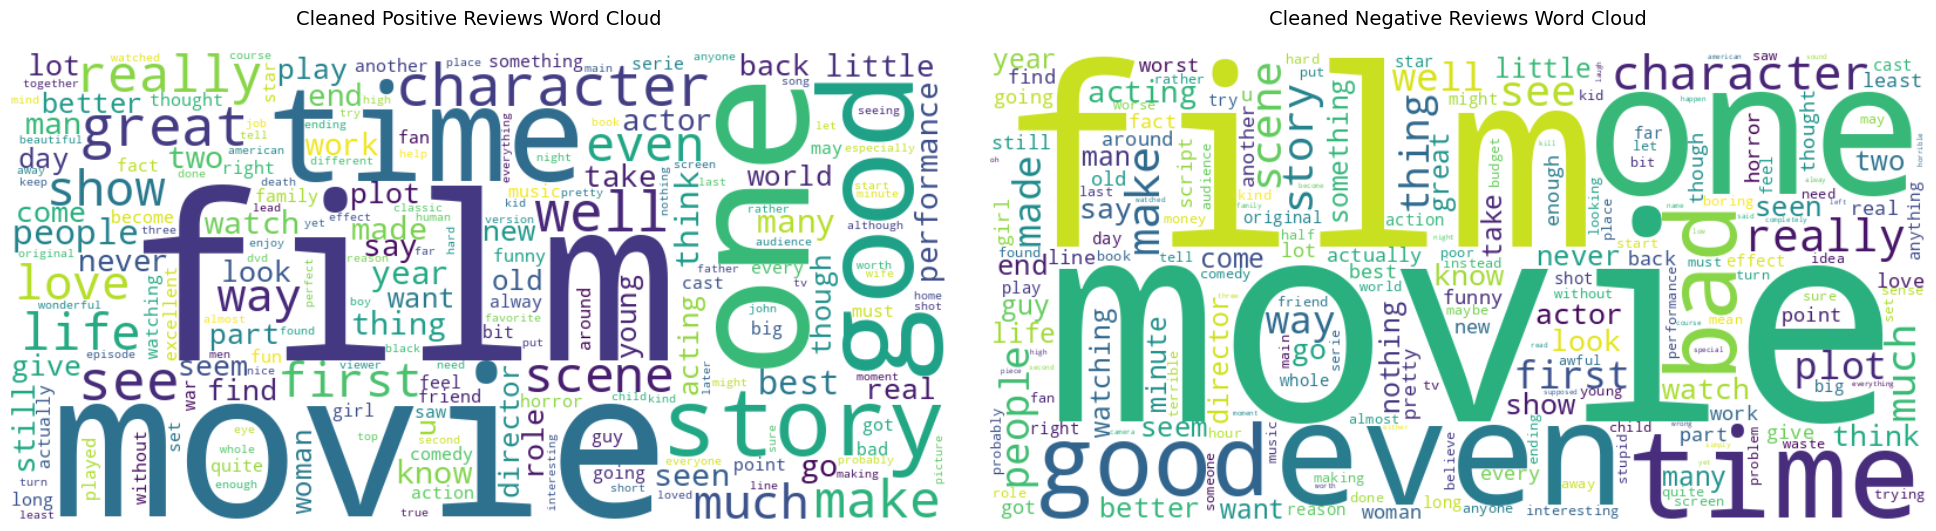

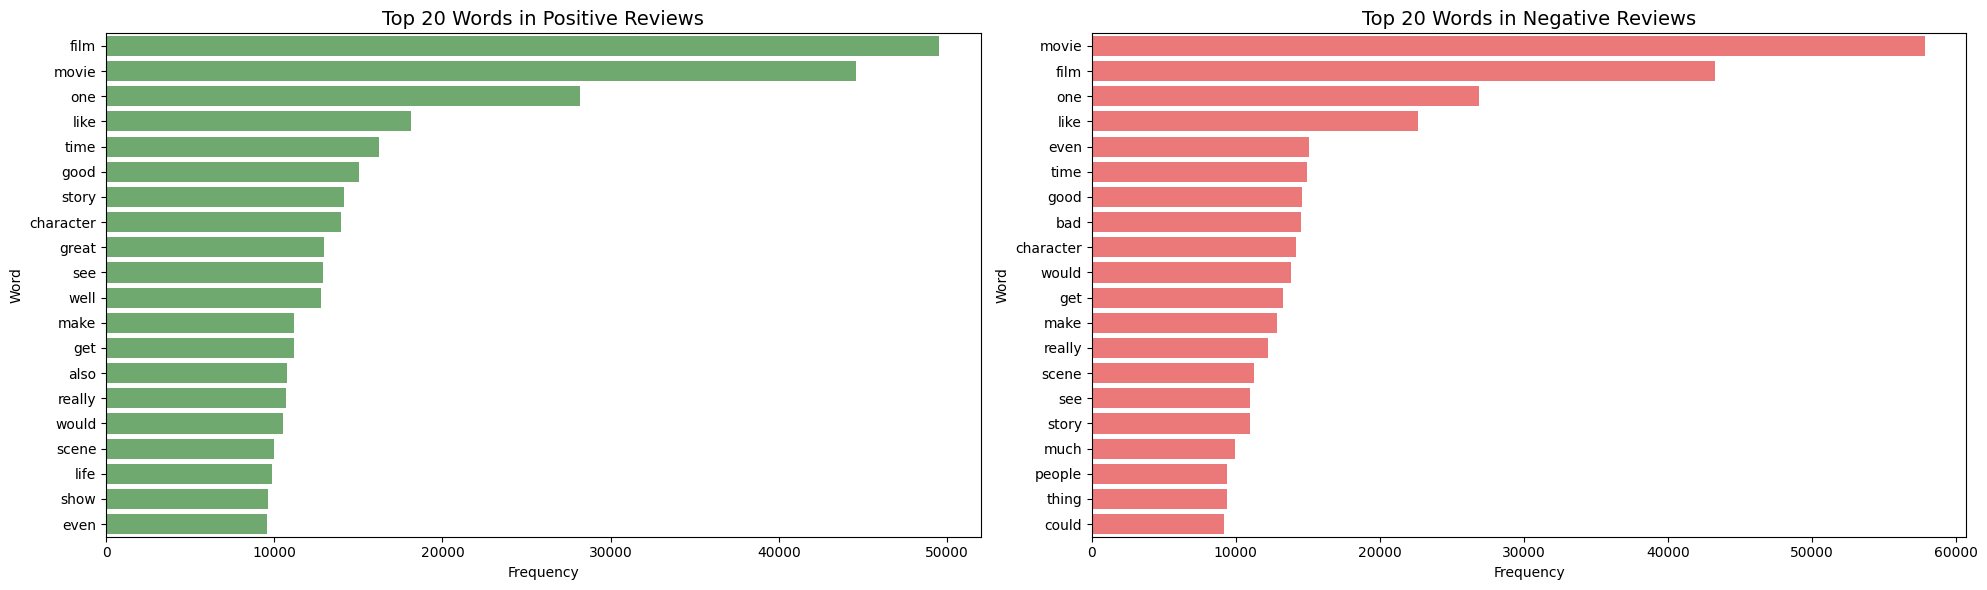


Comparison of Top Words:
     Positive Reviews   Negative Reviews
0        film (49528)      movie (57831)
1       movie (44616)       film (43248)
2         one (28163)        one (26849)
3        like (18119)       like (22648)
4        time (16237)       even (15085)
5        good (15033)       time (14946)
6       story (14140)       good (14616)
7   character (13957)        bad (14551)
8       great (12931)  character (14149)
9         see (12874)      would (13851)
10       well (12781)        get (13304)
11       make (11195)       make (12837)
12        get (11147)     really (12215)
13       also (10755)      scene (11260)
14     really (10701)        see (10979)
15      would (10545)      story (10956)
16      scene (10016)        much (9974)
17        life (9857)      people (9403)
18        show (9612)       thing (9358)
19        even (9566)       could (9181)


In [21]:
# Display word clouds for cleaned text
plt.figure(figsize=(20, 8))

# Positive Reviews Word Cloud
plt.subplot(1, 2, 1)
positive_cleaned_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
wordcloud_positive = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=200,
                             collocations=False).generate(positive_cleaned_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Positive Reviews Word Cloud', fontsize=14, pad=20)

# Negative Reviews Word Cloud
plt.subplot(1, 2, 2)
negative_cleaned_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review'])
wordcloud_negative = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=200,
                             collocations=False).generate(negative_cleaned_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Cleaned Negative Reviews Word Cloud', fontsize=14, pad=20)

plt.tight_layout(pad=3.0)
plt.show()

# Compare most common words in positive and negative reviews
def get_top_words(text, n=20):
    words = text.split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word', 'Count'])

# Get top words for each sentiment
pos_top_words = get_top_words(positive_cleaned_reviews)
neg_top_words = get_top_words(negative_cleaned_reviews)

# Plot bar charts side by side
plt.figure(figsize=(20, 6))

# Positive Reviews
plt.subplot(1, 2, 1)
sns.barplot(data=pos_top_words, x='Count', y='Word', color='green', alpha=0.6)
plt.title('Top 20 Words in Positive Reviews', fontsize=14)
plt.xlabel('Frequency')

# Negative Reviews
plt.subplot(1, 2, 2)
sns.barplot(data=neg_top_words, x='Count', y='Word', color='red', alpha=0.6)
plt.title('Top 20 Words in Negative Reviews', fontsize=14)
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

# Print the comparison table
print("\nComparison of Top Words:")
comparison_df = pd.DataFrame({
    'Positive Reviews': [f"{word} ({count})" for word, count in pos_top_words.values],
    'Negative Reviews': [f"{word} ({count})" for word, count in neg_top_words.values]
})
print(comparison_df.to_string())

### 6. Aspect Sentiment Analysis

In [27]:
# Install required packages if not already installed
import spacy
from textblob import TextBlob
from tqdm import tqdm

# Load the English language model for spaCy
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.add_pipe("sentencizer")


# Use only the first 20,000 rows
cleaned_df = cleaned_df.head(20000)

# Define aspect keywords for movie reviews
aspect_keywords = {
    'acting': ['actor', 'actress', 'cast', 'performance', 'role', 'played', 'acting', 'performs'],
    'direction': ['director', 'filmmaking', 'direction', 'directed', 'pacing', 'vision'],
    'story': ['plot', 'screenplay', 'narrative', 'story', 'writing', 'script', 'dialogue'],
    'visuals': ['cinematography', 'effects', 'camera', 'visual', 'cgi', 'shot', 'scenes', 'lighting']
}

def extract_aspect_sentiments(texts, aspect):
    """Efficiently extract sentiment for a list of texts on a specific aspect"""
    sentiments = []
    for doc in tqdm(nlp.pipe(texts, disable=["ner", "parser"]), total=len(texts), desc=f"Processing {aspect}"):
        try:
            sentences = [sent.text for sent in doc.sents
                         if any(keyword in sent.text.lower() for keyword in aspect_keywords[aspect])]
            if not sentences:
                sentiments.append(None)
                continue
            polarity = [TextBlob(sent).sentiment.polarity for sent in sentences]
            sentiments.append(sum(polarity) / len(polarity))
        except Exception as e:
            print(f"Error processing text: {e}")
            sentiments.append(None)
    return sentiments

# Run sentiment extraction for each aspect and add to DataFrame
for aspect in aspect_keywords.keys():
    cleaned_df[f'{aspect}_sentiment'] = extract_aspect_sentiments(cleaned_df['review'].astype(str).tolist(), aspect)



Processing visuals: 100%|██████████| 20000/20000 [03:02<00:00, 109.81it/s]


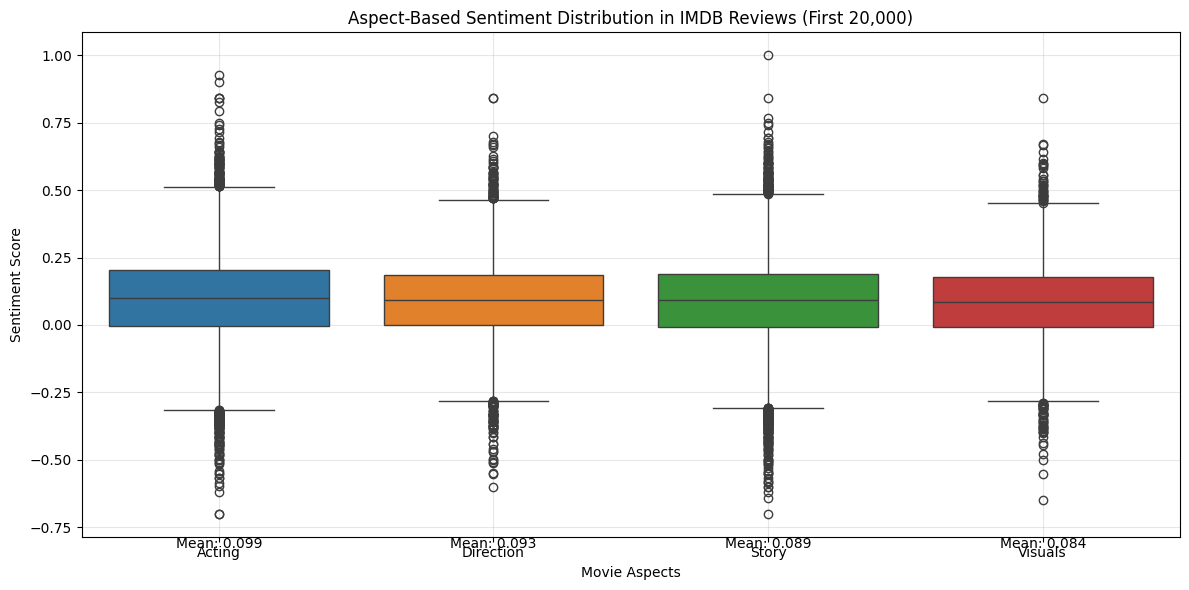


Aspect Sentiment Summary (First 20,000 Reviews):
       acting_sentiment  direction_sentiment  story_sentiment  \
count      11793.000000          5359.000000     11787.000000   
mean           0.099083             0.092703         0.088799   
std            0.168287             0.155012         0.162444   
min           -0.700000            -0.600000        -0.700000   
25%           -0.004524            -0.001050        -0.009136   
50%            0.099359             0.091886         0.091886   
75%            0.202696             0.185984         0.188988   
max            0.925000             0.840000         1.000000   

       visuals_sentiment  
count        4163.000000  
mean            0.083652  
std             0.149163  
min            -0.650000  
25%            -0.007574  
50%             0.084635  
75%             0.176377  
max             0.840000  


In [29]:
# Visualize aspect-based sentiment distribution
plt.figure(figsize=(12, 6))
sentiment_data = cleaned_df[['acting_sentiment', 'direction_sentiment',
                             'story_sentiment', 'visuals_sentiment']]

# Create boxplot
sns.boxplot(data=sentiment_data)
plt.title('Aspect-Based Sentiment Distribution in IMDB Reviews (First 20,000)')
plt.ylabel('Sentiment Score')
plt.xlabel('Movie Aspects')
plt.xticks(range(4), ['Acting', 'Direction', 'Story', 'Visuals'])
plt.grid(True, alpha=0.3)

# Add mean values as text
for i, col in enumerate(sentiment_data.columns):
    mean_val = sentiment_data[col].mean()
    plt.text(i, plt.ylim()[0], f'Mean: {mean_val:.3f}',
             horizontalalignment='center', verticalalignment='top')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAspect Sentiment Summary (First 20,000 Reviews):")
print(sentiment_data.describe())


**Conclusion:**

**BOX PLOT:**
* Viewers tend to express slightly positive sentiments across all aspects.

* Acting and Story are the most frequently discussed aspects (taller boxes = more data).

* Visuals is the least discussed (narrower box).


**Key Takeaways**
* Acting and Story are central to user sentiment.

* Overall, reviewers are mildly positive in tone.

* The sentiment range reveals both strong praise and harsh critique exist in reviews.


### 7. Sentiment Analysis Models

**Split into Training and Testing Sets**

In [ ]:
# Split the cleaned review text and sentiment labels into training and testing sets

from sklearn.model_selection import train_test_split

# Use the cleaned review text and mapped sentiment (binary) for splitting
X = cleaned_df['review']  # Cleaned review text
y = cleaned_df['sentiment_count']  # Binary sentiment label (1=positive, 0=negative)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

**Feature Engineering (TF-IDF)**

In [ ]:
# Initialize the TF-IDF vectorizer with custom parameters
tfidf = TfidfVectorizer(
    min_df=5,                # Ignore terms that appear in fewer than 5 documents
    max_df=0.6,              # Ignore terms that appear in more than 60% of documents
    ngram_range=(1, 2),      # Use unigrams and bigrams
    stop_words='english',    # Remove English stopwords
    max_features=10000       # Keep only the top 10,000 features
)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = tfidf.transform(X_test)

**A: Logistic Regression**

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Train a Logistic Regression classifier on TF-IDF features
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=10000)

Accuracy: 0.8917

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9075    0.8714    0.8891      7410
    Positive     0.8772    0.9119    0.8942      7465

    accuracy                         0.8917     14875
   macro avg     0.8924    0.8916    0.8916     14875
weighted avg     0.8923    0.8917    0.8916     14875


Confusion Matrix:
[[6457  953]
 [ 658 6807]]


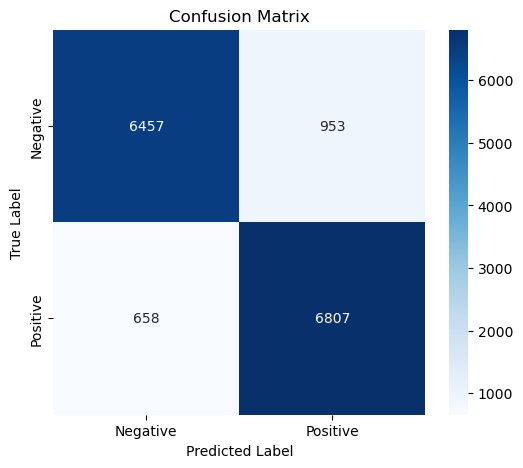

In [ ]:
# Step 2: Make predictions on the test set
y_pred = log_reg_model.predict(X_test_tfidf)

# Step 3: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], digits=4))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Train a Multinomial Naive Bayes classifier on TF-IDF features
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.8596

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8737    0.8394    0.8562      7410
    Positive     0.8466    0.8796    0.8628      7465

    accuracy                         0.8596     14875
   macro avg     0.8601    0.8595    0.8595     14875
weighted avg     0.8601    0.8596    0.8595     14875


Confusion Matrix:
[[6220 1190]
 [ 899 6566]]


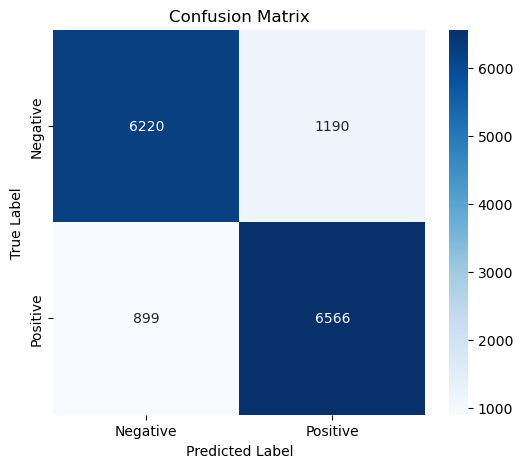

In [ ]:
# Step 2: Make predictions on the test set
y_pred_nb = mnb_model.predict(X_test_tfidf)

# Step 3: Evaluate the model
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Negative', 'Positive'], digits=4))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 8. Hyperparameter Tuning, Cross Validation and Fine Tuned Model

**A: Logistic Regression**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)

# Define the hyperparameter grid
param_grid = {
    'C': np.linspace(1, 4, 30),         # Regularization strength values
    'penalty': ['l1', 'l2'],            # l2 is standard, l1 requires solver='liblinear'
    'solver': ['liblinear']             # Supports both l1 and l2 penalties
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model with the best hyperparameters using TF-IDF features
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_log_reg = grid_search.best_estimator_

# Print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'C': 2.4482758620689653, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy: 0.8873714330328586


**Multinomial Naive Bayes**

In [ ]:
# Define the Multinomial Naive Bayes model
mnb = MultinomialNB()

# Define the range of alpha values to search
alphas = np.linspace(0.01, 6.0, 30)

# Define parameter grid for tuning
param_grid = {'alpha': alphas}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model with the best hyperparameters using TF-IDF features
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_mnb = grid_search.best_estimator_

# Print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'alpha': 3.1082758620689654}
Best cross-validated accuracy: 0.8576945387038158


**LSTM**

In [ ]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.15

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Step 1: Tokenization and Sequence Preparation
tokenizer = Tokenizer(num_words=10000)  # Consider top 10,000 words
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Step 2: Padding sequences to ensure uniform length
max_len = 200  # Maximum length of each review
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Step 3: Build LSTM model
embedding_dim = 128  # Dimension of word embeddings

model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train_pad, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

# Step 5: Make predictions
y_pred_prob = model.predict(X_test_pad)
y_pred_lstm = (y_pred_prob > 0.5).astype(int)



e:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 441s 785ms/step - accuracy: 0.7501 - loss: 0.4912 - val_accuracy: 0.8778 - val_loss: 0.3024
Epoch 2/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 411s 757ms/step - accuracy: 0.9030 - loss: 0.2555 - val_accuracy: 0.8834 - val_loss: 0.3208
Epoch 3/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 392s 722ms/step - accuracy: 0.9222 - loss: 0.2128 - val_accuracy: 0.8763 - val_loss: 0.3718
Epoch 4/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 408s 751ms/step - accuracy: 0.9373 - loss: 0.1717 - val_accuracy: 0.8785 - val_loss: 0.3543
Epoch 5/5
543/543 ━━━━━━━━━━━━━━━━━━━━ 414s 764ms/step - accuracy: 0.9491 - loss: 0.1381 - val_accuracy: 0.8767 - val_loss: 0.3636
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step



LSTM Model Accuracy: 0.8767

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8742    0.8789    0.8766      7410
    Positive     0.8792    0.8745    0.8768      7465

    accuracy                         0.8767     14875
   macro avg     0.8767    0.8767    0.8767     14875
weighted avg     0.8767    0.8767    0.8767     14875


Confusion Matrix:
[[6513  897]
 [ 937 6528]]


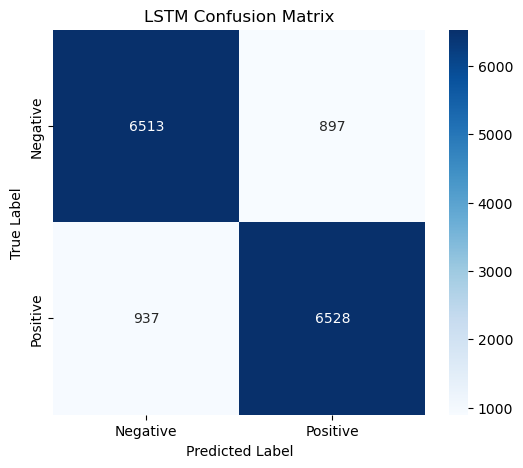

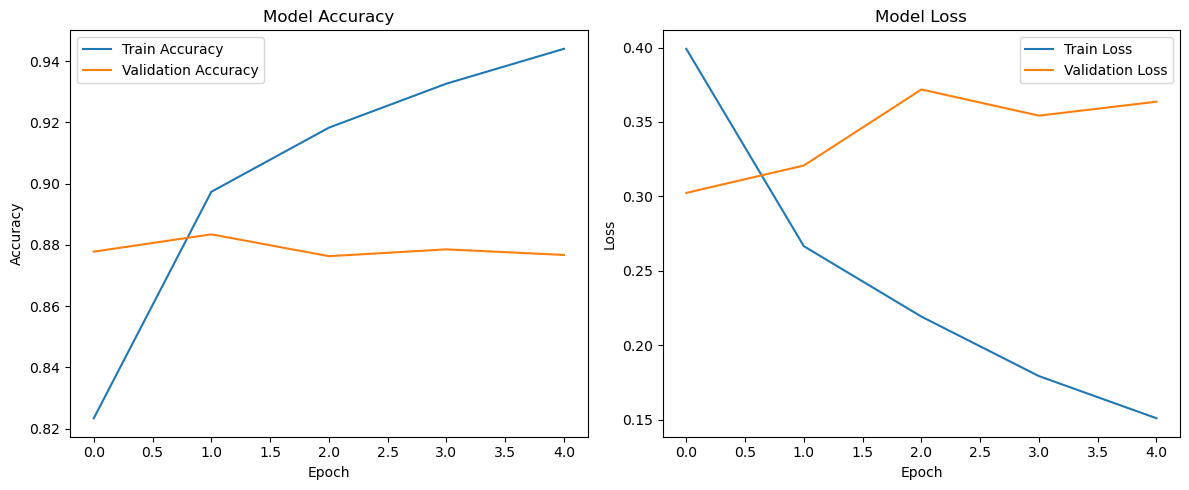

In [ ]:
# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"\nLSTM Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive'], digits=4))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lstm)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('LSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### 9. Check Overfitting

**Train vs Test Accuracy**

Model                   Train Acc     Test Acc         Diff
--------------------------------------------------------
Logistic Regression        0.9361       0.8914       0.0447
Multinomial NB             0.8727       0.8612       0.0114


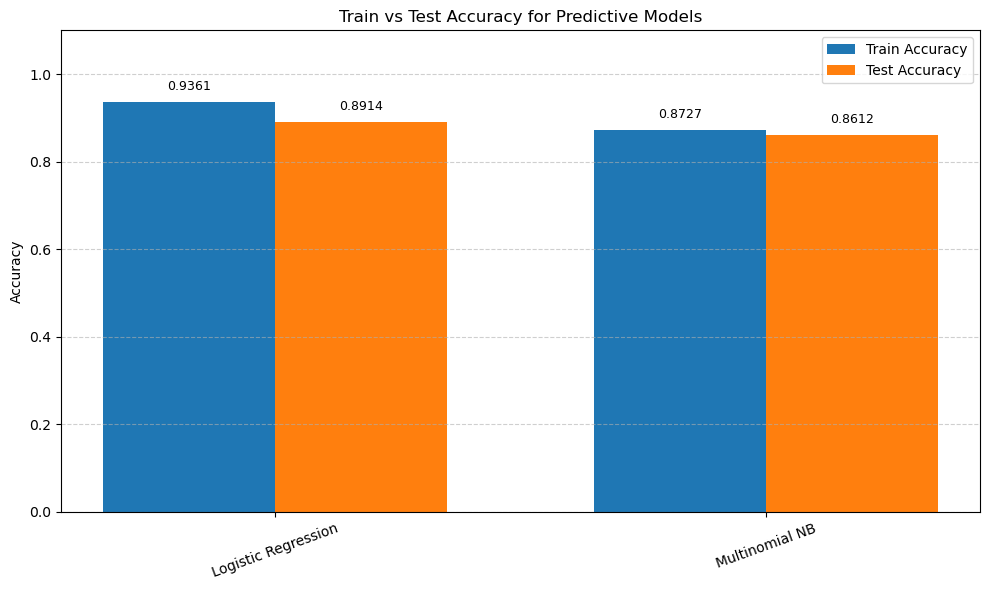

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Store results
results = {
    'Model': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'Difference': []
}

# List of models with labels
models = {
    'Logistic Regression': best_log_reg,
    'Multinomial NB': best_mnb,
}

# Evaluate each model
for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train_tfidf))
    test_acc = accuracy_score(y_test, model.predict(X_test_tfidf))
    diff = train_acc - test_acc

    results['Model'].append(name)
    results['Train Accuracy'].append(train_acc)
    results['Test Accuracy'].append(test_acc)
    results['Difference'].append(diff)

# === Print table of results ===
print(f"{'Model':<20} {'Train Acc':>12} {'Test Acc':>12} {'Diff':>12}")
print("-" * 56)
for i in range(len(results['Model'])):
    print(f"{results['Model'][i]:<20} {results['Train Accuracy'][i]:>12.4f} {results['Test Accuracy'][i]:>12.4f} {results['Difference'][i]:>12.4f}")

# === Plot Bar Chart ===
x = range(len(results['Model']))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar([i - width/2 for i in x], results['Train Accuracy'], width=width, label='Train Accuracy')
bars2 = plt.bar([i + width/2 for i in x], results['Test Accuracy'], width=width, label='Test Accuracy')

# Add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, results['Model'], rotation=20)
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.title('Train vs Test Accuracy for Predictive Models')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**ROC Curve**

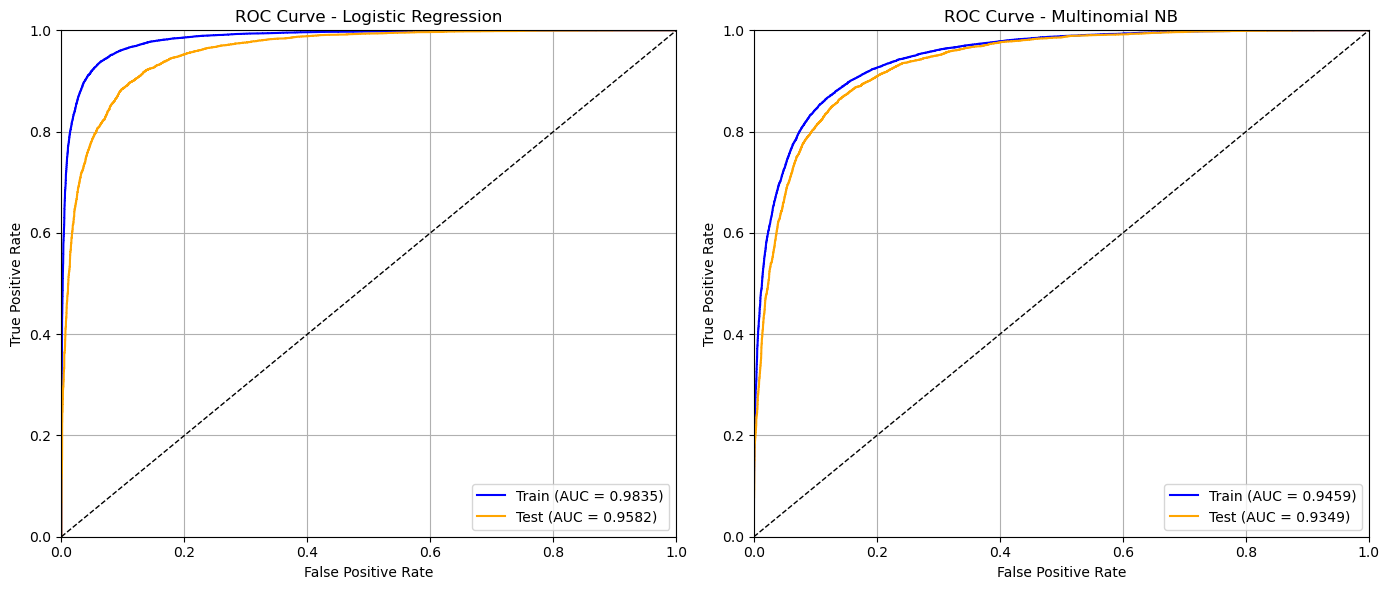

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to get decision scores or probabilities
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        return model.predict(X)

# List of models and names
models = {
    'Logistic Regression': best_log_reg,
    'Multinomial NB': best_mnb
}

# Use the correct feature matrices for ROC (TF-IDF, not raw text)
X_train_features = X_train_tfidf
X_test_features = X_test_tfidf

# Use correct label variable names (lowercase, as in your code)
y_train = y_train
y_test = y_test

# Create subplots: 1 row x 2 columns (since you have 2 models)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.ravel()  # Flatten for easy iteration

for i, (model_name, model) in enumerate(models.items()):
    ax = axes[i]

    # Train ROC
    y_train_score = get_scores(model, X_train_features)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    auc_train = auc(fpr_train, tpr_train)

    # Test ROC
    y_test_score = get_scores(model, X_test_features)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curves
    ax.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', color='blue')
    ax.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.4f})', color='orange')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title(f'ROC Curve - {model_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid(True)
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

### 10. Evaluation Report

In [ ]:
# Evaluation Report for Best Models after Hyperparameter Tuning
from sklearn import metrics

# Evaluate best Logistic Regression model
lr_accuracy = metrics.accuracy_score(y_test, best_log_reg.predict(X_test_tfidf))
print("Best Logistic Regression Model:")
print("Accuracy: ", str('{:04.2f}'.format(lr_accuracy * 100)) + "%\n")

print("Classification Report:")
print(classification_report(y_test, best_log_reg.predict(X_test_tfidf),
                          target_names=['Negative', 'Positive'], digits=4))

# Evaluate best Multinomial NB model
nb_accuracy = metrics.accuracy_score(y_test, best_mnb.predict(X_test_tfidf))
print("\nBest Multinomial NB Model:")
print("Accuracy: ", str('{:04.2f}'.format(nb_accuracy * 100)) + "%\n")

print("Classification Report:")
print(classification_report(y_test, best_mnb.predict(X_test_tfidf),
                          target_names=['Negative', 'Positive'], digits=4))

# Evaluate LSTM model
lstm_accuracy = metrics.accuracy_score(y_test, y_pred_lstm)
print("\nLSTM Model:")
print("Accuracy: ", str('{:04.2f}'.format(lstm_accuracy * 100)) + "%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_lstm,
                          target_names=['Negative', 'Positive'], digits=4))

# Calculate additional metrics for LSTM
lstm_precision = metrics.precision_score(y_test, y_pred_lstm)
lstm_recall = metrics.recall_score(y_test, y_pred_lstm)
lstm_f1 = metrics.f1_score(y_test, y_pred_lstm)

# Compare model performances with detailed metrics
print("\nDetailed Model Comparison:")
print("-" * 70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 70)

# Logistic Regression metrics
lr_precision = metrics.precision_score(y_test, best_log_reg.predict(X_test_tfidf))
lr_recall = metrics.recall_score(y_test, best_log_reg.predict(X_test_tfidf))
lr_f1 = metrics.f1_score(y_test, best_log_reg.predict(X_test_tfidf))
print(f"{'Logistic Regression':<20} {lr_accuracy:.4f} {lr_precision:.4f} {lr_recall:.4f} {lr_f1:.4f}")

# Multinomial NB metrics
nb_precision = metrics.precision_score(y_test, best_mnb.predict(X_test_tfidf))
nb_recall = metrics.recall_score(y_test, best_mnb.predict(X_test_tfidf))
nb_f1 = metrics.f1_score(y_test, best_mnb.predict(X_test_tfidf))
print(f"{'Multinomial NB':<20} {nb_accuracy:.4f} {nb_precision:.4f} {nb_recall:.4f} {nb_f1:.4f}")

# LSTM metrics
print(f"{'LSTM':<20} {lstm_accuracy:.4f} {lstm_precision:.4f} {lstm_recall:.4f} {lstm_f1:.4f}")



Best Logistic Regression Model:
Accuracy:  89.14%

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9025    0.8768    0.8895      7410
    Positive     0.8811    0.9060    0.8933      7465

    accuracy                         0.8914     14875
   macro avg     0.8918    0.8914    0.8914     14875
weighted avg     0.8917    0.8914    0.8914     14875


Best Multinomial NB Model:
Accuracy:  86.12%

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8744    0.8425    0.8581      7410
    Positive     0.8491    0.8798    0.8642      7465

    accuracy                         0.8612     14875
   macro avg     0.8617    0.8612    0.8612     14875
weighted avg     0.8617    0.8612    0.8612     14875


LSTM Model:
Accuracy:  87.67%

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8742    0.8789    0.8766      7410
    Positive     0.8792    0.8745    0

C:\Users\NT\AppData\Local\Temp\ipykernel_3624\612587492.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=temp_df, x='True Label', y='Predicted Score', ax=ax, palette='Set2')
C:\Users\NT\AppData\Local\Temp\ipykernel_3624\612587492.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=temp_df, x='True Label', y='Predicted Score', ax=ax, palette='Set2')
C:\Users\NT\AppData\Local\Temp\ipykernel_3624\612587492.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=temp_df, x='True Label', y='Predicted Score', ax=ax, palette='Set2'

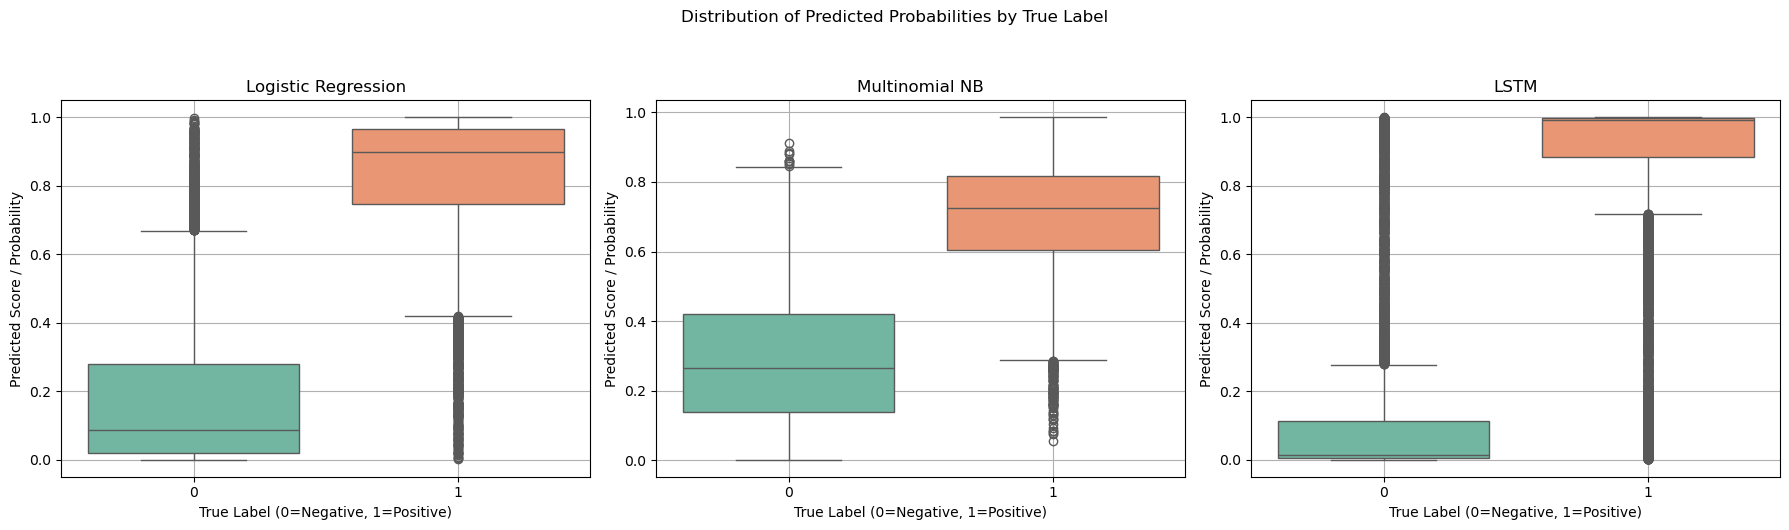

In [ ]:
# 1. Box Plot of Predicted Scores
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Update models dictionary to include LSTM
models = {
    'Logistic Regression': best_log_reg,
    'Multinomial NB': best_mnb,
    'LSTM': 'lstm'  # Special identifier for LSTM
}

# Create subplots for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Updated to 3 columns
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    ax = axes[i]

    # Get predicted probabilities
    if name == 'LSTM':
        y_score = y_pred_prob.flatten()  # Use LSTM probabilities
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_score = model.predict(X_test_tfidf)

    # Create DataFrame for plotting
    temp_df = pd.DataFrame({
        'Predicted Score': y_score,
        'True Label': y_test
    })

    # Create box plot
    sns.boxplot(data=temp_df, x='True Label', y='Predicted Score', ax=ax, palette='Set2')
    ax.set_title(f"{name}")
    ax.set_xlabel("True Label (0=Negative, 1=Positive)")
    ax.set_ylabel("Predicted Score / Probability")
    ax.grid(True)

plt.suptitle('Distribution of Predicted Probabilities by True Label', y=1.05)
plt.tight_layout()
plt.show()

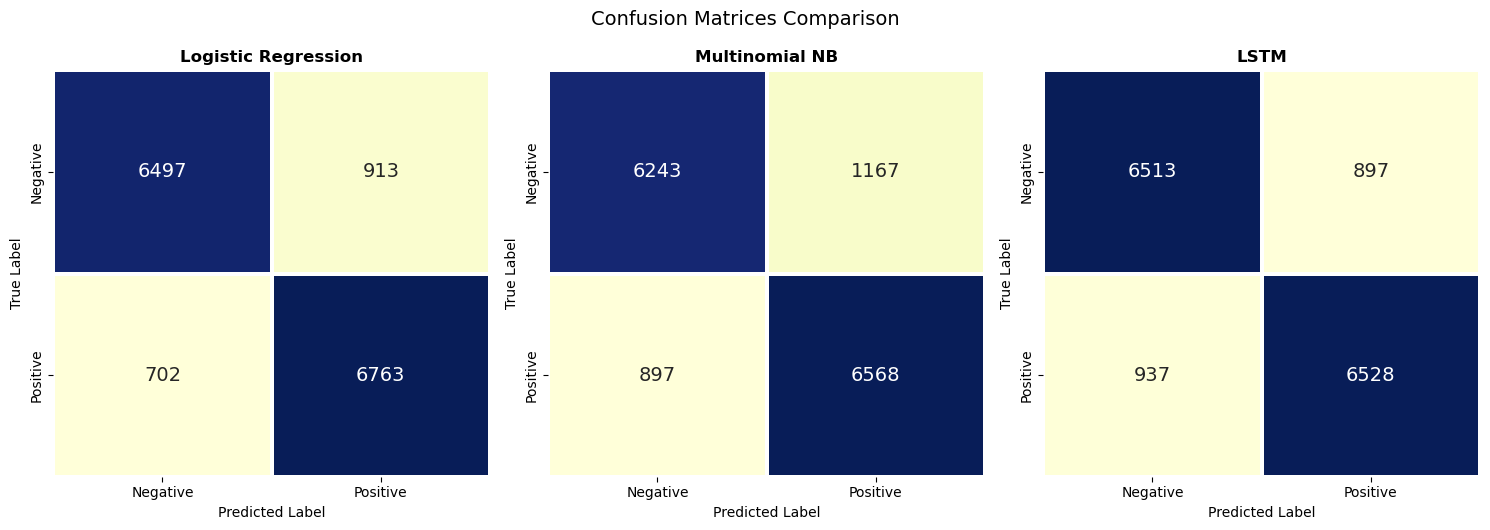

In [ ]:
# 2. Enhanced Confusion Matrices with LSTM
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Updated to 3 subplots
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    if name == 'LSTM':
        y_pred = y_pred_lstm
    else:
        y_pred = model.predict(X_test_tfidf)

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar=False,
                linewidths=1.5, linecolor='white',
                annot_kws={"size": 14},
                ax=axes[i])

    axes[i].set_title(f"{name}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Predicted Label", fontsize=10)
    axes[i].set_ylabel("True Label", fontsize=10)

plt.tight_layout()
plt.suptitle("Confusion Matrices Comparison", fontsize=14, y=1.05)
plt.show()

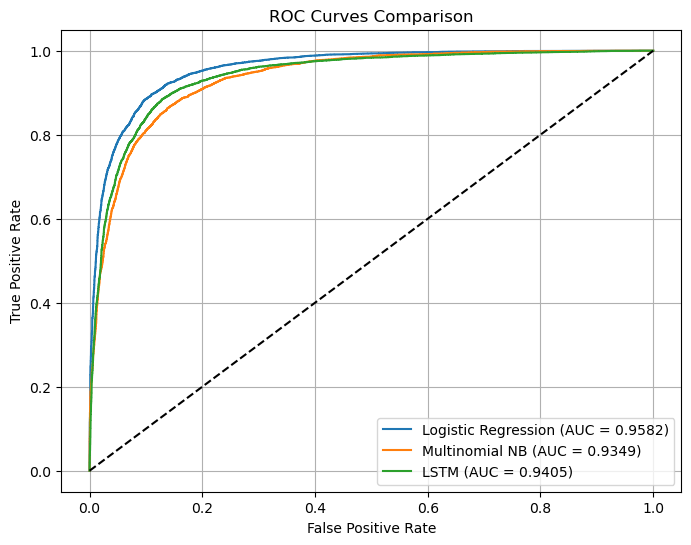

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(8, 6))

# ROC curve for Logistic Regression
lr_probs = best_log_reg.predict_proba(X_test_tfidf)[:, 1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {metrics.auc(lr_fpr, lr_tpr):.4f})')

# ROC curve for Multinomial NB
nb_probs = best_mnb.predict_proba(X_test_tfidf)[:, 1]
nb_fpr, nb_tpr, _ = metrics.roc_curve(y_test, nb_probs)
plt.plot(nb_fpr, nb_tpr, label=f'Multinomial NB (AUC = {metrics.auc(nb_fpr, nb_tpr):.4f})')

# ROC curve for LSTM
lstm_fpr, lstm_tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {metrics.auc(lstm_fpr, lstm_tpr):.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

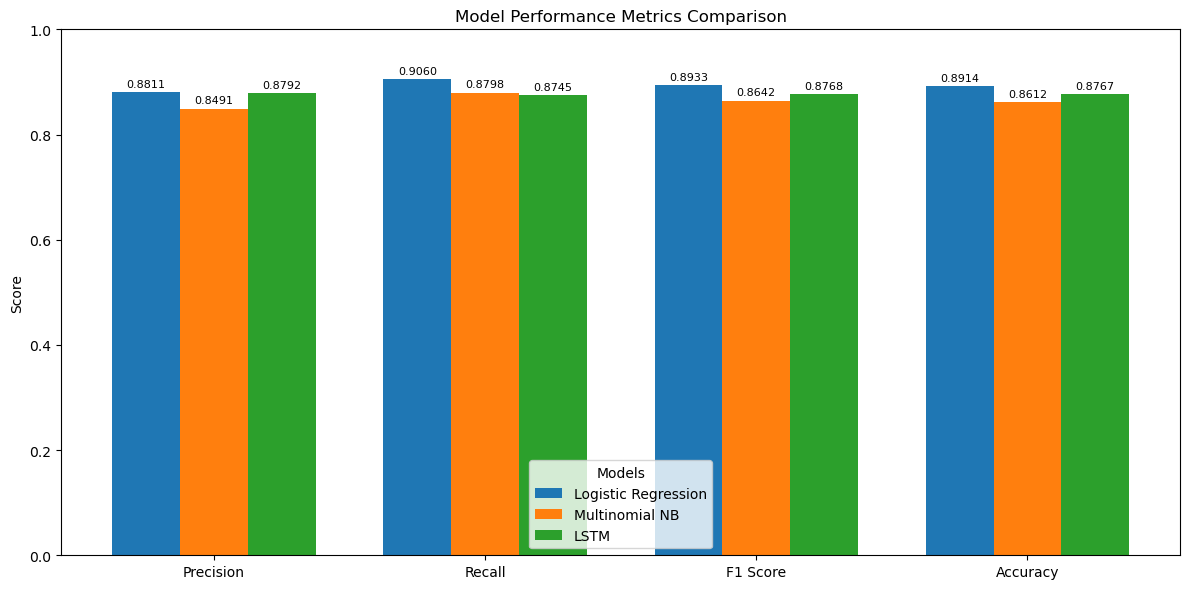

In [ ]:
# 4. Metrics Comparison Bar Plot
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
scores = {model: [] for model in models}

for name, model in models.items():
    if name == 'LSTM':
        y_pred = y_pred_lstm
    else:
        y_pred = model.predict(X_test_tfidf)

    scores[name].append(precision_score(y_test, y_pred))
    scores[name].append(recall_score(y_test, y_pred))
    scores[name].append(f1_score(y_test, y_pred))
    scores[name].append(accuracy_score(y_test, y_pred))

x = np.arange(len(metric_names))
width = 0.25  # Adjusted for 3 models

plt.figure(figsize=(12, 6))

for i, (model_name, model_scores) in enumerate(scores.items()):
    plt.bar(x + i * width, model_scores, width=width,
            label=model_name, color=model_colors[model_name])

plt.xticks(x + width, metric_names)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Model Performance Metrics Comparison')
plt.legend(title='Models')

for i, (model_name, model_scores) in enumerate(scores.items()):
    for j, score in enumerate(model_scores):
        plt.text(x[j] + i * width, score + 0.01,
                f"{score:.4f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()